# If using Google Colab

### Change your runtime to GPU for better performance

Click on the arrow in the upper right corner.

<img src="https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/images/change_runtime_type.png" alt="change runtime" width="400"/>

Select the T4 GPU option.

<img src="https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/images/choose_T4_gpu.png" alt="select GPU" width="400"/>

# Confirm that you are connected to a GPU

In [158]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


# Install & import libraries

In [159]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.integrate import odeint
import scipy.optimize

import sympy as sp

import pandas as pd
import pandas

import copy
import os

In [160]:
try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

In [161]:
try:
    from keras_visualizer import visualizer
except:
    !pip install keras-visualizer
    from keras_visualizer import visualizer

In [162]:
import tensorflow as tf
from tensorflow.python.client import device_lib
import keras
from IPython.display import display, Image

In [163]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

planar_drone = import_local_or_github('planar_drone', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')
generate_training_data_utility = import_local_or_github('generate_training_data_utility', directory='../Utility')

# Download, load, and clean data as in Lesson 11.B

In [164]:
generate_training_data_utility.download_data('planar_drone_trajectories.zip')

Fetching from: 
<Response [200]>
unzipping...


In [165]:
traj_list = generate_training_data_utility.load_trajectory_data('planar_drone_trajectories')

Number of trajectories: 
3001


In [166]:
traj_list = generate_training_data_utility.clean_trajectory_data(traj_list)

Number of good trajectories: 
2924


# Add some noise -- to make this a little more realistic

In [167]:
def add_noise_to_trajectory_data(traj_list, noise_std):
    exclude_columns = exclude_columns = ['time', 'objid'] # don't add noise to time or the objid!
    noise_distribution = scipy.stats.norm(0, noise_std)

    for i, trajec in enumerate(traj_list):
        for col in trajec.keys():
            if col not in exclude_columns:
                trajec[col] += noise_distribution.rvs(trajec.shape[0])
                traj_list[i] = trajec

    return traj_list

In [168]:
noise_std = 0.02
traj_list = add_noise_to_trajectory_data(traj_list, noise_std)

# Look at a trajectory

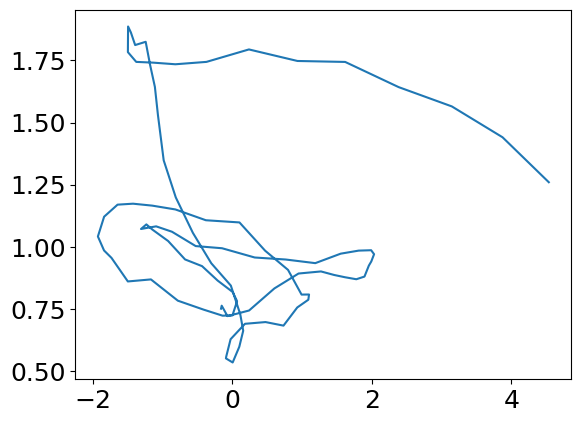

In [169]:
i = 520
traj = traj_list[i]
plt.plot(traj.x, traj.z)

# Set input & output variables

We want an estimator that takes the available sensor information and estimates the altitude. Since our model assumes that the camera is on a gimble and is always pointed down, $\theta$ is irrelevant.

In [170]:
output_names = ['z']

In [171]:
input_names =  ['sensor_optic_flow', 'sensor_accel_x', 'sensor_accel_z']

# Augment data so each row contains delay-embedded inputs and the outputs

We will collect inputs from a time window leading up to the final time point for which we want to estimate the altitude. This ensures that there is, theoretically, enough information to actually estimate the altitude, provided the time window contains enough dynamic movement to ensure observability.

This function was written with more generality in mind so we can reuse it later in scenarios where we have states and controls, and may want to consider them seperately.

In [172]:
# This function was written by Ben Cellini, and subsequently expanded by Claude to provide further functionality
def collect_offset_rows(df, states=None, controls=None, outputs=None,
                        state_offsets=None, control_offsets=None, output_offsets=None):
    """ Takes a pandas data frame with n rows and creates an augmented data frame that collects
        rows at specified offsets for different column types (states, controls, outputs).

        Inputs
            df: pandas data frame
            states: list of column names to treat as states
            controls: list of column names to treat as controls
            outputs: list of column names to treat as outputs
            state_offsets: list of integer offsets for state columns (default: [-1])
            control_offsets: list of integer offsets for control columns (default: [-1])
            output_offsets: list of integer offsets for output columns (default: [0])

            Offset interpretation:
                - Negative values look backward (e.g., -1 is previous row, -2 is two rows back)
                - Zero includes current row
                - Positive values look forward (e.g., 1 is next row, 2 is two rows ahead)

        Outputs
            df_aug: augmented pandas data frame.
                    Columns are organized by type and offset:
                    - First all state columns (grouped by offset)
                    - Then all control columns (grouped by offset)
                    - Finally all output columns (grouped by offset)
                    New columns are named: old_name_offset_N (e.g., 'x_offset_-1', 'u_offset_0')
                    Only rows where all offsets are valid are included.
    """
    import pandas as pd
    import numpy as np
    df = df.reset_index(drop=True)

    # Set defaults
    if state_offsets is None:
        state_offsets = [-1]
    if control_offsets is None:
        control_offsets = [-1]
    if output_offsets is None:
        output_offsets = [0]

    # Collect all columns and offsets to determine valid row range
    all_columns = []
    all_offsets = []

    column_groups = []
    if states is not None and len(states) > 0:
        all_columns.extend(states)
        all_offsets.extend(state_offsets)
        column_groups.append(('states', states, state_offsets))

    if controls is not None and len(controls) > 0:
        all_columns.extend(controls)
        all_offsets.extend(control_offsets)
        column_groups.append(('controls', controls, control_offsets))

    if outputs is not None and len(outputs) > 0:
        all_columns.extend(outputs)
        all_offsets.extend(output_offsets)
        column_groups.append(('outputs', outputs, output_offsets))

    if len(all_columns) == 0:
        raise ValueError("At least one of states, controls, or outputs must be specified")

    # Determine valid row range
    min_offset = min(all_offsets)
    max_offset = max(all_offsets)

    n_row = df.shape[0]

    # Valid rows are those where all offsets point to existing rows
    start_row = max(0, -min_offset)
    end_row = min(n_row, n_row - max_offset)
    n_row_train = end_row - start_row

    if n_row_train <= 0:
        raise ValueError(f"No valid rows with given offsets. DataFrame has {n_row} rows, "
                        f"but offsets range from {min_offset} to {max_offset}")

    # Build augmented dataframe by processing each column group
    df_aug_parts = []

    for group_name, columns, offsets in column_groups:
        # For each offset in this group
        for offset in offsets:
            source_indices = np.arange(start_row, end_row) + offset

            # For each column with this offset
            for col in columns:
                data = df.loc[source_indices, col].reset_index(drop=True)
                col_name = f'{col}_offset_{offset}'
                df_aug_parts.append(pd.DataFrame({col_name: data}))

    # Combine all parts
    df_aug = pd.concat(df_aug_parts, axis=1)

    return df_aug

### Perform the augmentation

In [173]:
# ignore the first and last few frames to prevent artifacts
trim_edges = 5

# use a time window of 10 steps -- adjust if you need larger windows for observability
time_window = 10

In [174]:
# construct the input offsets, and show them
input_offsets = np.arange(time_window)*-1
print(input_offsets)

[ 0 -1 -2 -3 -4 -5 -6 -7 -8 -9]


In [175]:
# we only need to estimate altitude at the final time step
output_offsets = [0]

In [176]:
# build a augmented trajectory for each trajectory in the list
traj_augment_list = []
for traj in traj_list:
    traj_augment = collect_offset_rows(traj[trim_edges:-1*trim_edges],
                                       states=input_names,
                                       controls=None,
                                       outputs=output_names,
                                       state_offsets=input_offsets,
                                       control_offsets=None,
                                       output_offsets=output_offsets)

    traj_augment_list.append(traj_augment)

# combine all the trajectories into a single data frame
traj_augment_all = pd.concat(traj_augment_list, ignore_index=True)

In [177]:
# display the data frame to see what the column names are
np.round(traj_augment_all, 4)

,sensor_optic_flow_offset_0,sensor_accel_x_offset_0,sensor_accel_z_offset_0,sensor_optic_flow_offset_-1,sensor_accel_x_offset_-1,sensor_accel_z_offset_-1,sensor_optic_flow_offset_-2,sensor_accel_x_offset_-2,sensor_accel_z_offset_-2,sensor_optic_flow_offset_-3,...,sensor_optic_flow_offset_-7,sensor_accel_x_offset_-7,sensor_accel_z_offset_-7,sensor_optic_flow_offset_-8,sensor_accel_x_offset_-8,sensor_accel_z_offset_-8,sensor_optic_flow_offset_-9,sensor_accel_x_offset_-9,sensor_accel_z_offset_-9,z_offset_0
0,1.1515,0.0102,-9.8200,1.1484,0.0025,-9.8456,1.2511,0.0060,-9.8036,1.3190,...,2.1311,-0.0176,-9.8007,2.5793,-0.0382,-9.7981,3.2253,7.5292,-1.9935,17.1857
1,1.0164,-2.8082,-6.9832,1.1515,0.0102,-9.8200,1.1484,0.0025,-9.8456,1.2511,...,1.8656,-0.0278,-9.7987,2.1311,-0.0176,-9.8007,2.5793,-0.0382,-9.7981,18.0388
2,0.9731,-6.1389,-3.5953,1.0164,-2.8082,-6.9832,1.1515,0.0102,-9.8200,1.1484,...,1.6147,-0.0328,-9.8184,1.8656,-0.0278,-9.7987,2.1311,-0.0176,-9.8007,18.7197
3,0.9388,-10.0119,0.2200,0.9731,-6.1389,-3.5953,1.0164,-2.8082,-6.9832,1.1515,...,1.4688,0.0208,-9.8116,1.6147,-0.0328,-9.8184,1.8656,-0.0278,-9.7987,19.4061
4,0.8442,-13.6803,3.8753,0.9388,-10.0119,0.2200,0.9731,-6.1389,-3.5953,1.0164,...,1.3190,-0.0253,-9.8081,1.4688,0.0208,-9.8116,1.6147,-0.0328,-9.8184,20.0668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207599,0.1962,-5.3723,-2.0746,0.1488,-2.3325,-0.5189,0.2158,1.0567,1.2163,0.1610,...,0.1171,3.1357,12.9946,0.0945,3.4258,11.6803,0.0557,1.2283,9.2472,17.6482
207600,0.0970,-6.9757,-2.8232,0.1962,-5.3723,-2.0746,0.1488,-2.3325,-0.5189,0.2158,...,0.1038,0.4110,12.6002,0.1171,3.1357,12.9946,0.0945,3.4258,11.6803,17.9053
207601,0.0519,-6.5564,-2.0635,0.0970,-6.9757,-2.8232,0.1962,-5.3723,-2.0746,0.1488,...,0.1358,0.8241,10.5353,0.1038,0.4110,12.6002,0.1171,3.1357,12.9946,18.1057
207602,0.0468,-4.2460,-1.6008,0.0519,-6.5564,-2.0635,0.0970,-6.9757,-2.8232,0.1962,...,0.1514,3.5877,7.0835,0.1358,0.8241,10.5353,0.1038,0.4110,12.6002,18.2886


### Calculate the number of inputs and outputs

For the neural network with augmented data, we now have more inputs corresponding to the time-history of sensory measurements

In [178]:
n_input = len(input_names) * time_window
n_output = len(output_names)

print('Inputs:', n_input)
print('Output:', n_output)

Inputs: 30
Output: 1


### Seperate inputs & outputs

In [179]:
# Input data
X = traj_augment_all.iloc[:, 0:n_input]
X

,sensor_optic_flow_offset_0,sensor_accel_x_offset_0,sensor_accel_z_offset_0,sensor_optic_flow_offset_-1,sensor_accel_x_offset_-1,sensor_accel_z_offset_-1,sensor_optic_flow_offset_-2,sensor_accel_x_offset_-2,sensor_accel_z_offset_-2,sensor_optic_flow_offset_-3,...,sensor_accel_z_offset_-6,sensor_optic_flow_offset_-7,sensor_accel_x_offset_-7,sensor_accel_z_offset_-7,sensor_optic_flow_offset_-8,sensor_accel_x_offset_-8,sensor_accel_z_offset_-8,sensor_optic_flow_offset_-9,sensor_accel_x_offset_-9,sensor_accel_z_offset_-9
0,1.151526,0.010177,-9.820028,1.148364,0.002456,-9.845618,1.251060,0.005967,-9.803647,1.319028,...,-9.798743,2.131061,-0.017559,-9.800721,2.579328,-0.038186,-9.798130,3.225345,7.529173,-1.993487
1,1.016412,-2.808192,-6.983235,1.151526,0.010177,-9.820028,1.148364,0.002456,-9.845618,1.251060,...,-9.818390,1.865557,-0.027788,-9.798743,2.131061,-0.017559,-9.800721,2.579328,-0.038186,-9.798130
2,0.973099,-6.138877,-3.595272,1.016412,-2.808192,-6.983235,1.151526,0.010177,-9.820028,1.148364,...,-9.811591,1.614703,-0.032809,-9.818390,1.865557,-0.027788,-9.798743,2.131061,-0.017559,-9.800721
3,0.938754,-10.011918,0.219974,0.973099,-6.138877,-3.595272,1.016412,-2.808192,-6.983235,1.151526,...,-9.808109,1.468815,0.020844,-9.811591,1.614703,-0.032809,-9.818390,1.865557,-0.027788,-9.798743
4,0.844216,-13.680254,3.875294,0.938754,-10.011918,0.219974,0.973099,-6.138877,-3.595272,1.016412,...,-9.803647,1.319028,-0.025277,-9.808109,1.468815,0.020844,-9.811591,1.614703,-0.032809,-9.818390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207599,0.196227,-5.372256,-2.074566,0.148807,-2.332536,-0.518930,0.215787,1.056725,1.216323,0.160977,...,12.600156,0.117055,3.135683,12.994560,0.094522,3.425796,11.680343,0.055651,1.228255,9.247204
207600,0.097008,-6.975720,-2.823197,0.196227,-5.372256,-2.074566,0.148807,-2.332536,-0.518930,0.215787,...,10.535309,0.103769,0.411030,12.600156,0.117055,3.135683,12.994560,0.094522,3.425796,11.680343
207601,0.051900,-6.556419,-2.063513,0.097008,-6.975720,-2.823197,0.196227,-5.372256,-2.074566,0.148807,...,7.083501,0.135777,0.824061,10.535309,0.103769,0.411030,12.600156,0.117055,3.135683,12.994560
207602,0.046773,-4.246009,-1.600790,0.051900,-6.556419,-2.063513,0.097008,-6.975720,-2.823197,0.196227,...,3.582645,0.151357,3.587734,7.083501,0.135777,0.824061,10.535309,0.103769,0.411030,12.600156


In [180]:
# Output data
Y = traj_augment_all.iloc[:, n_input:]
Y

,z_offset_0
0,17.185668
1,18.038777
2,18.719702
3,19.406111
4,20.066807
...,...
207599,17.648186
207600,17.905253
207601,18.105738
207602,18.288611


# Construct neural network model
We will start with a basic feedforward network structure with three dense hidden layers.

A detailed guide to layer types, activation functions, loss functions, etc. can be found here: https://keras.io/api/layers/



### Define architecture and build function, build model

We will save the architecture, and the build_model function is saved in `keras_ann_utility.py`.

This maximizes portability of the model.

In [181]:
# Define model architecture
input_architecture = [
    {'core_input_dim': n_input},
]
core_architecture = [
    {'units': 50, 'activation': 'relu'},
    {'units': 50, 'activation': 'relu'},
    {'units': 20, 'activation': 'relu'},
    {'units': n_output, 'activation': 'linear'}
]

In [182]:
def build_model(input_architecture, core_architecture):
    model = keras.models.Sequential() # sequential model means that each layer has one set of inputs & one set of outputs (no recurrence)
    n_input = input_architecture[0]['core_input_dim']

    for i, layer in enumerate(core_architecture):
        if i == 0:
            model.add(keras.layers.Dense(layer['units'], 
                            input_dim=n_input, 
                            activation=layer['activation'])) # add a dense layer with 50 neurons & rectified linear unit (ReLU) activation function
        else:
            model.add(keras.layers.Dense(layer['units'], 
                            activation=layer['activation']))
    return model

In [183]:
model = build_model(input_architecture, core_architecture)

### Compile the model: set the loss function & optimizer

In [184]:
model.compile(loss='mean_squared_error', # set the loss function
              optimizer='adam', # optimzer (stochastic gradient descent method: https://arxiv.org/abs/1412.6980)
              metrics=['mean_absolute_error']) # list of other metrics to compute when traning

Model structure

In [185]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 50)                1550      
                                                                 
 dense_17 (Dense)            (None, 50)                2550      
                                                                 
 dense_18 (Dense)            (None, 20)                1020      
                                                                 
 dense_19 (Dense)            (None, 1)                 21        
                                                                 
Total params: 5141 (20.08 KB)
Trainable params: 5141 (20.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Visualize the model
Note the image displayed below shows truncated hidden layers

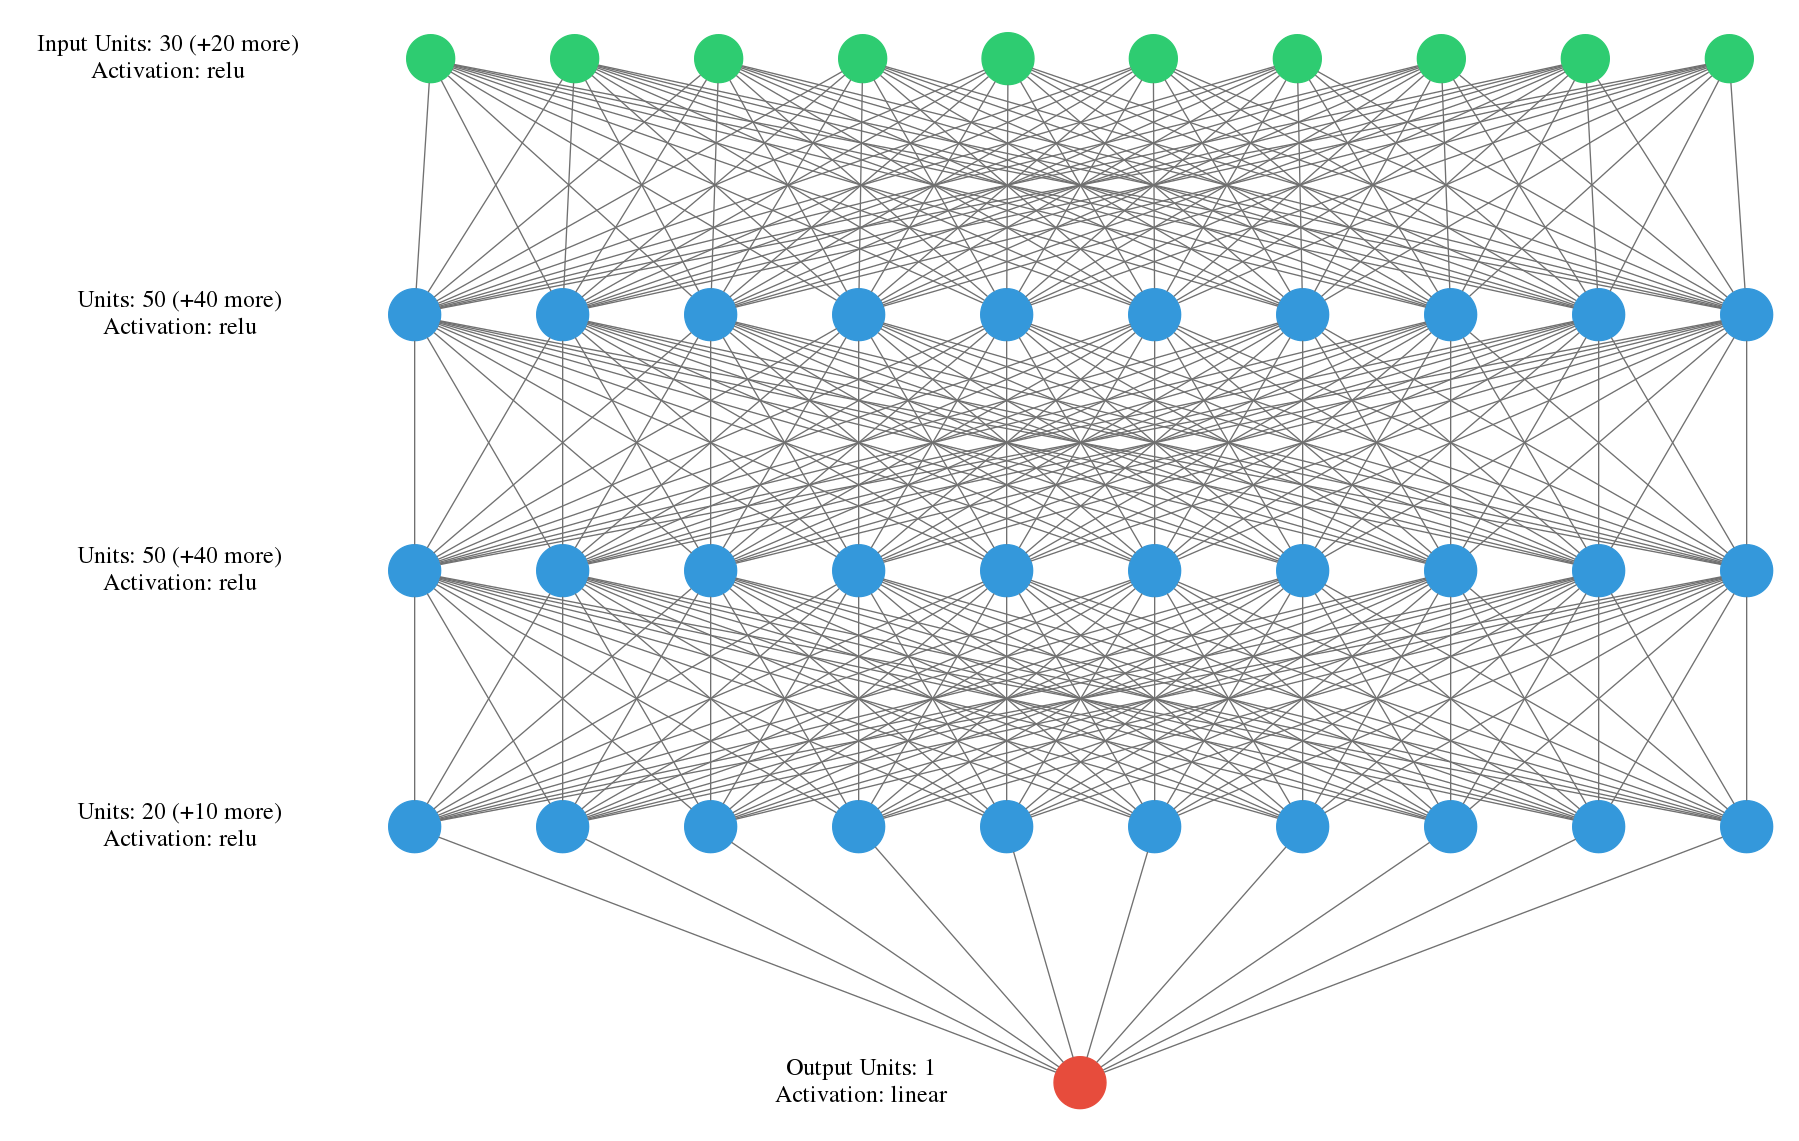

In [186]:
visualizer(model, file_format='png', view=False) # saves an image: graph.png
display(Image(filename='graph.png'))

# Train model
***This will take a little while to run. It will be faster on a GPU runtime.***

The `batch_size` hyperparameter sets the number of samples used during training before updating the model. Larger batch sizes will train faster but may be less stable/accurate.

The `epochs` hyperparameter sets the number of iterations the model will train over the entire dataset. More epochs will generally improve accuracy, but has diminishing returns over time.

The `validation_split` hyperparameter specifies what ratio of your training data that is withheld during training to test the network accuracy.

`verbose` just sets how much output to display and does not affect the model itself.

### Show if the GPU is being used.

In [187]:
import subprocess

# from Claude
class GPUMonitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 1 == 0:  # Check every 5 epochs
            try:
                result = subprocess.run(['nvidia-smi', '--query-gpu=utilization.gpu,memory.used,memory.total',
                                      '--format=csv,noheader,nounits'],
                                      capture_output=True, text=True)
                gpu_util, mem_used, mem_total = result.stdout.strip().split(', ')
                print(f"\n[GPU] Utilization: {gpu_util}%, Memory: {mem_used}/{mem_total} MB")
            except:
                print(f"\nNo GPU found")

In [188]:
model_data = model.fit(X, Y, epochs=5, batch_size=256, validation_split=0.2, verbose=1,
                       callbacks=[GPUMonitor()])

Epoch 1/5
649/649 [==============================] - ETA: 0s - loss: 33.7349 - mean_absolute_error: 4.2959
[GPU] Utilization: 0%, Memory: 1166/4037 MB
649/649 [==============================] - 3s 3ms/step - loss: 33.7349 - mean_absolute_error: 4.2959 - val_loss: 18.2429 - val_mean_absolute_error: 3.0730
Epoch 2/5
634/649 [============================>.] - ETA: 0s - loss: 16.0533 - mean_absolute_error: 2.6500
[GPU] Utilization: 0%, Memory: 1166/4037 MB
649/649 [==============================] - 2s 3ms/step - loss: 16.0470 - mean_absolute_error: 2.6456 - val_loss: 12.9346 - val_mean_absolute_error: 2.4168
Epoch 3/5
643/649 [============================>.] - ETA: 0s - loss: 12.9940 - mean_absolute_error: 2.2447
[GPU] Utilization: 0%, Memory: 1166/4037 MB
649/649 [==============================] - 2s 3ms/step - loss: 12.9607 - mean_absolute_error: 2.2433 - val_loss: 11.1063 - val_mean_absolute_error: 2.1234
Epoch 4/5
630/649 [============================>.] - ETA: 0s - loss: 11.6951 - mea

# Evaluate the training and model

### Loss function over time

This curves should go down, and the red curve should remain below the blue curve. If the red curve goes above the blue curve, you are overfitting the model.

Text(0, 0.5, 'loss')

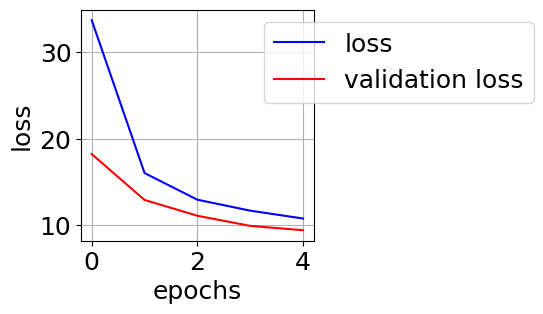

In [189]:
model_history = pd.DataFrame(model_data.history)

fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=100)

ax.plot(model_history.loss,
        '-',
        label='loss',
        color='blue')

ax.plot(model_history.val_loss,
        '-',
        label='validation loss',
        color='red')

ax.grid()
ax.legend(bbox_to_anchor=(2.0, 1.0))

ax.set_xlabel('epochs')
ax.set_ylabel('loss')

### Evaluate training accuracy

Run model on training data. We will speed this up in the next notebook.

In [190]:
Y_predict = model.predict(X, batch_size=4096)

51/51 [==============================] - 0s 3ms/step


Plot a distribution of the error.

In [191]:
z_predict = Y_predict[:,0]
z_true = Y['z_offset_0'].values

In [192]:
z_error = z_predict - z_true
z_mean_error = np.mean(z_error)
z_std_error = np.std(z_error)
print('mean error:', np.round(z_mean_error, 4))
print('mean std:', np.round(z_std_error, 4))

mean error: 0.219
mean std: 3.1668


Text(0, 0.5, 'Count')

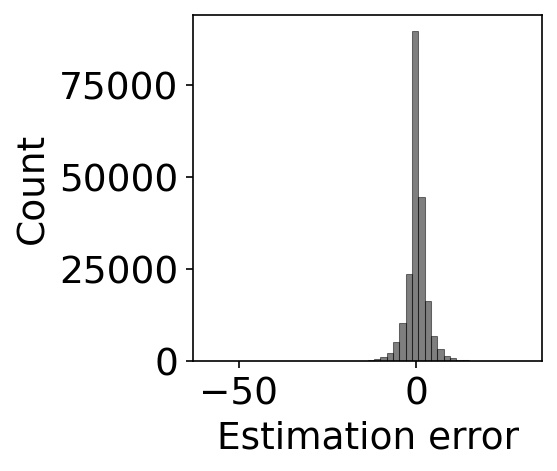

In [193]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=150)
hist_data = ax.hist(z_error, bins=50, facecolor='black', alpha=0.5, edgecolor='black', linewidth=0.5)
ax.set_xlabel('Estimation error')
ax.set_ylabel('Count')

Plot a comparison of the true vs predicted.

Text(0.5, 0, 'True z')

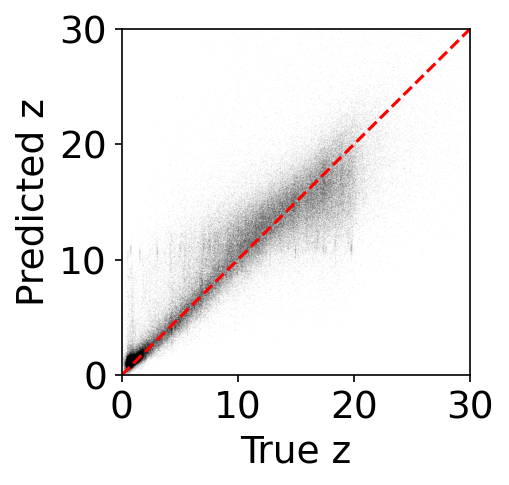

In [194]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=150)

z_line = np.arange(np.min(z_true), np.max(z_true), 1)


ax.scatter(z_true, z_predict, s=0.2, c='black', alpha=0.05, edgecolors='none')
ax.plot(z_line, z_line, '--', color='red')

ax.set_xlim(0, 30)
ax.set_ylim(0, 30)

ax.set_ylabel('Predicted z')
ax.set_xlabel('True z')

Plot a distribution of errors as a function of acceleration. Here you can see the manifestation of observability implications.

In [195]:
cols = [col for col in X if col.startswith('sensor_accel_x')]
mean_accels = X[cols].mean(axis=1)

In [196]:
min_accels = np.abs(X[cols]).min(axis=1)

Text(0, 0.5, 'altitude error')

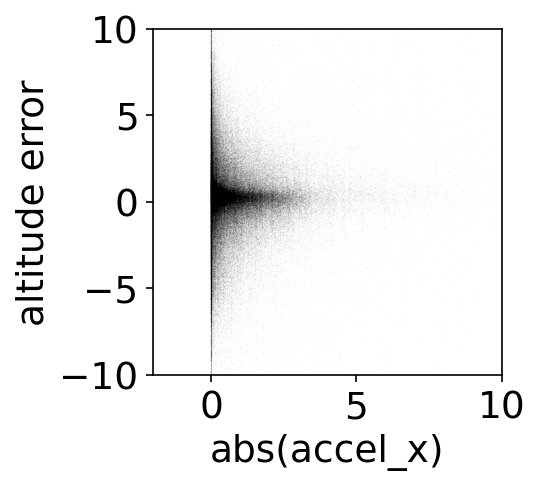

In [197]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=150)

ax.scatter(min_accels, z_error, s=0.2, c='black', alpha=0.05, edgecolors='none')

ax.set_ylim(-10, 10)
ax.set_xlim(-2, 10)

ax.set_xlabel('abs(accel_x)')
ax.set_ylabel('altitude error')

# Save model

In [199]:
def save_model_complete(model, filepath, input_architecture, core_architecture):
    """
    Save model weights and complete configuration for easy reloading.
    
    Parameters:
    -----------
    model : keras.Model
        Trained model to save
    filepath : str
        Base filepath (without extension), e.g., 'my_model'
    input_architecture : dict
        Dict with 'core_input_dim'
    core_architecture : list of dict
        Core branch architecture specification
    
    """
    import json
    
    # Save weights
    weights_path = f"{filepath}_weights.h5"
    model.save_weights(weights_path)
    print(f"✓ Saved weights to: {weights_path}")
    
    # Save complete configuration
    config = {
        'input_architecture': input_architecture,
        'core_architecture': core_architecture,
    }
    
    config_path = f"{filepath}_config.json"
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=2)
    print(f"✓ Saved configuration to: {config_path}")
    
    print(f"\nModel saved successfully!")
    print(f"To load: model = load_model_complete('{filepath}')")

In [200]:
save_model_complete(model, 'altitude_estimator_ann_trained', input_architecture, core_architecture)

✓ Saved weights to: altitude_estimator_ann_trained_weights.h5
✓ Saved configuration to: altitude_estimator_ann_trained_config.json

Model saved successfully!
To load: model = load_model_complete('altitude_estimator_ann_trained')


# Load model

In [205]:
def load_model_complete(filepath):
    """
    Load model weights and configuration.
    
    Parameters:
    -----------
    filepath : str
        Base filepath (without extension), same as used in save_model_complete
    
    Returns:
    --------
    model : keras.Model
        Loaded model ready for inference, to continue training need to compile
    config : dict
        Complete configuration dictionary
    
    """
    import json
    
    # Load configuration
    config_path = f"{filepath}_config.json"
    with open(config_path, 'r') as f:
        config = json.load(f)
    print(f"✓ Loaded configuration from: {config_path}")
    
    # Rebuild model with same architecture
    model = build_model(input_architecture, core_architecture)
    
    # Load weights
    weights_path = f"{filepath}_weights.h5"
    model.load_weights(weights_path)
    print(f"✓ Loaded weights from: {weights_path}")
    
    print(f"\nModel loaded successfully!")
    
    return model, config

In [206]:
model, config = load_model_complete('altitude_estimator_ann_trained')

✓ Loaded configuration from: altitude_estimator_ann_trained_config.json
✓ Loaded weights from: altitude_estimator_ann_trained_weights.h5

Model loaded successfully!


In [213]:
config['input_architecture']

[{'core_input_dim': 30}]

# Alternate Save and Load

This is much simpler, and will work in many cases. However, if you are transfering your model across systems, python versions, keras versions, etc., it might break, and the method above is more robust.

In [207]:
model_path = 'altitude_estimator_network_trained.keras' # download this, or change location to google drive to save indefinitely
model.save(model_path)

In [211]:
model_loaded = keras.models.load_model(model_path)